# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

14:00:31 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=865015;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=10375;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=434491;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=647509;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

14:01:31 INFO      Auto-determined polynomial order: 0                                ]8;id=853015;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=774574;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

14:01:49 INFO      None 0-order polynomial fit with the mle method                               ]8;id=939064;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=641775;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=589264;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=961606;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=505233;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=408655;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=475720;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=274282;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=400565;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=600566;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

14:01:50 INFO      Auto-probed noise models:                                                    ]8;id=856302;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=123756;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=179466;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=667897;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=932830;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=145766;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=529927;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=165695;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

14:01:53 INFO      Now using 120 bins                                                          ]8;id=49553;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=465120;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

14:01:56 INFO      Auto-determined polynomial order: 1                                ]8;id=981567;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=595718;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

14:02:14 INFO      None 1-order polynomial fit with the mle method                               ]8;id=609337;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=388495;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=782258;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=333986;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=17194;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=344150;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

14:02:15 INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=480618;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=288299;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=409654;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=865246;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=218789;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=8227;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=9147;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=282047;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=758584;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=318023;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=263696;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=782966;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=522875;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=616449;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

14:02:17 INFO      Auto-determined polynomial order: 1                                ]8;id=317984;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=725142;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

14:02:36 INFO      None 1-order polynomial fit with the mle method                               ]8;id=387176;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=490752;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=176669;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=395400;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=190365;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=310727;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=488901;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=863971;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=532041;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=274452;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

14:02:37 INFO      Auto-probed noise models:                                                    ]8;id=575689;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=769811;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=652514;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=289431;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=353790;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=700919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=663823;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=435153;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=777718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=34348;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

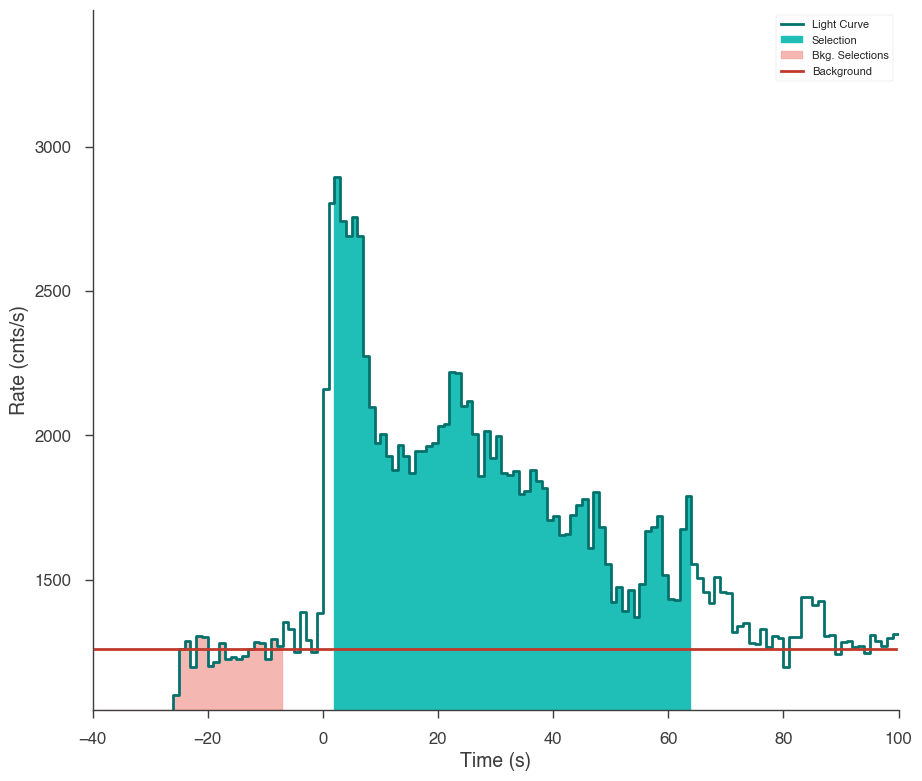

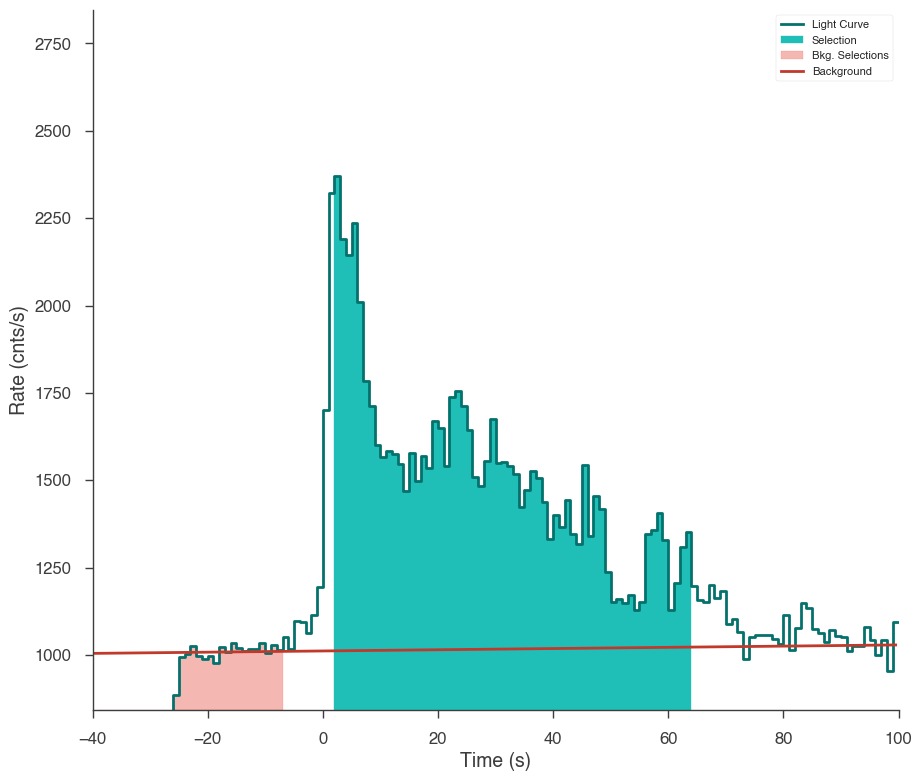

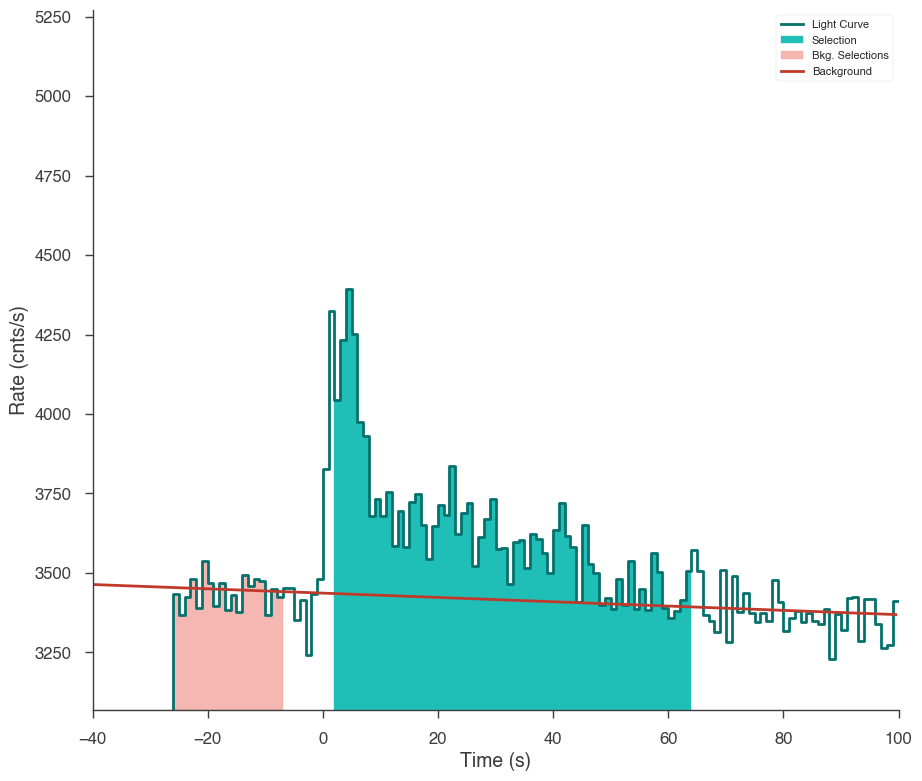

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

14:02:38 INFO      sampler set to multinest                                                ]8;id=525722;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=933608;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

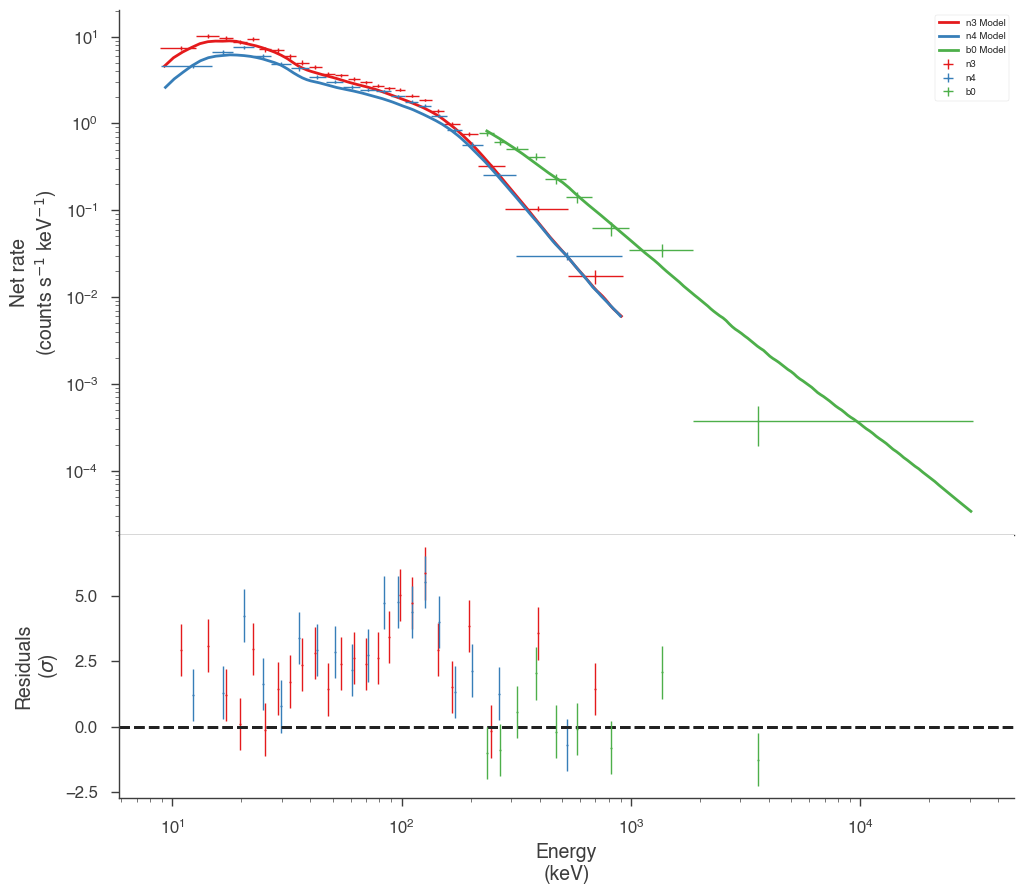

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3102.4939577327305      +/-  0.22916578142385560     
 Total Likelihood Evaluations:        20329
 Sampling finished. Exiting MultiNest



14:03:01 INFO      fit restored to maximum of posterior                                         ]8;id=26663;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=86346;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=473810;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=786745;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.471 -0.014 +0.022) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                -1.0958 +0.0018 +0.035                 
GRB080916009...break_energy    (1.884 +0.027 +0.35) x 10^2              keV
GRB080916009...break_scale         (0.0 +1.0 +2.6) x 10^-1                 
GRB080916009...beta                    -1.984 -0.10 +0.010

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1049.158200
n3        -1020.307843
n4        -1010.014650
total     -3079.480693

Values of statistical measures:

statistical measures
AIC              6169.131840
BIC              6188.364051
DIC              6177.938040
PDIC                3.363963
log(Z)          -1347.396006

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=612997;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=115288;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

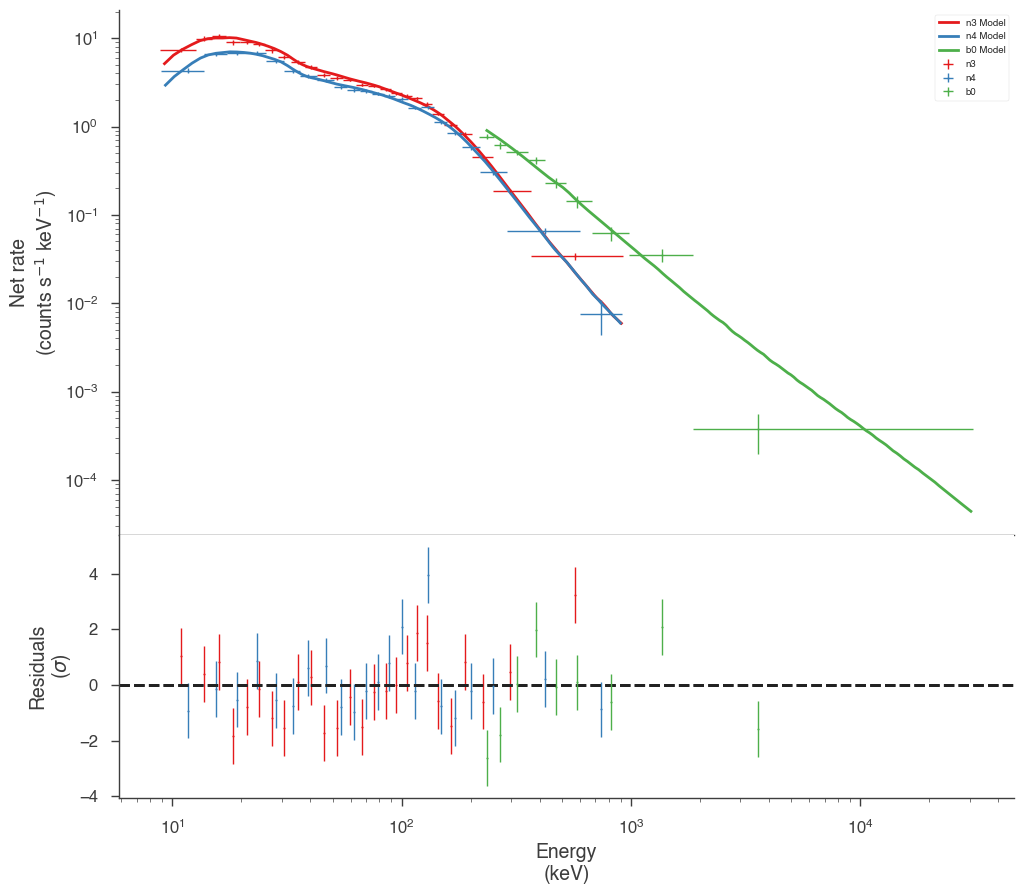

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

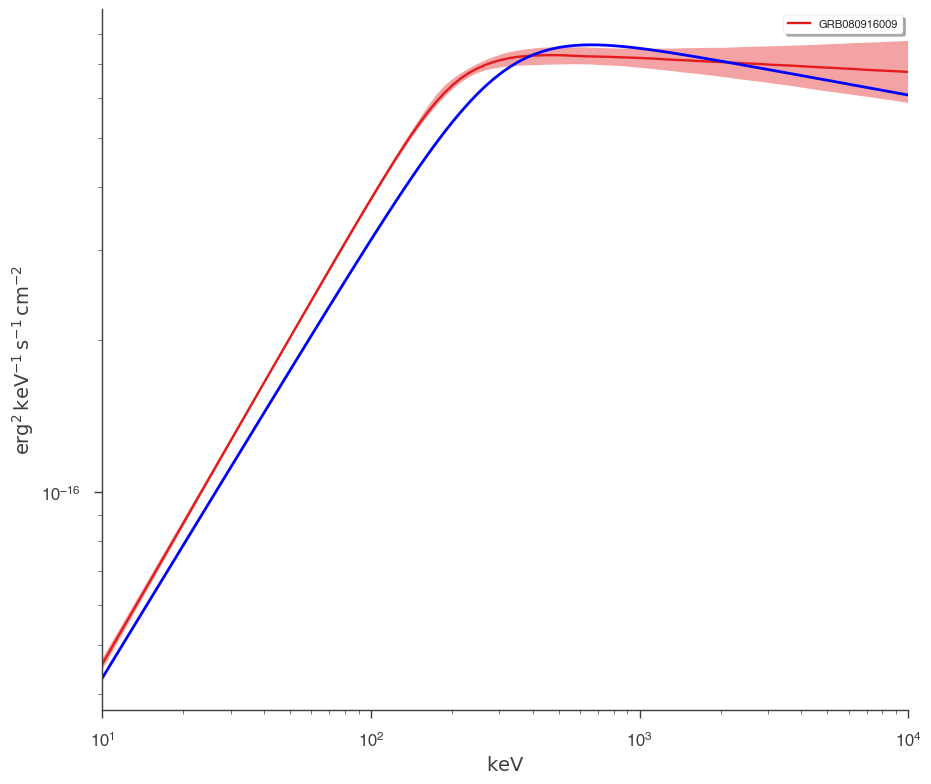

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

14:05:07 INFO      Created 15 bins via bayesblocks                                       ]8;id=677855;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=350457;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


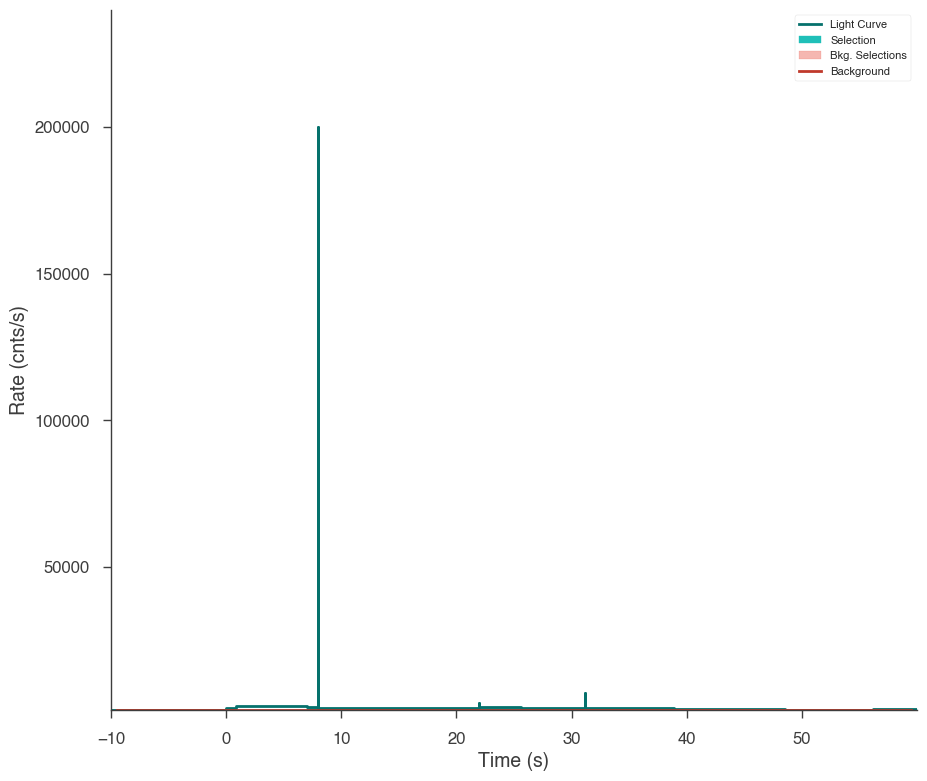

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=858137;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=468392;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

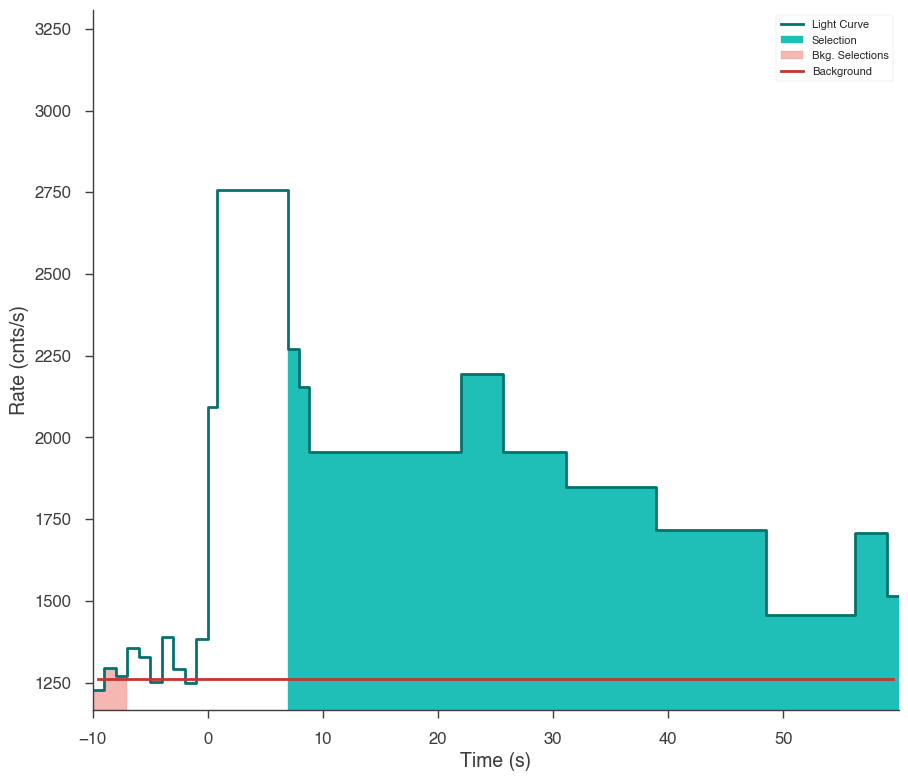

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=189470;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=55307;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

14:05:08 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=380741;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=374152;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=450587;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=440802;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=541984;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=302806;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

14:05:09 INFO      Created 12 bins via custom                                            ]8;id=128690;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=917493;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

14:05:10 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=864277;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=116366;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=964736;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=538638;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=649729;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=987955;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=516651;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=26280;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=328732;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=784007;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=650853;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=661092;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 107 bins                                                          ]8;id=824522;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=281902;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=427233;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=489277;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -788.02712963121382      +/-  0.17487751124201134     
 Total Likelihood Evaluations:        16494
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


14:05:26 INFO      fit restored to maximum of posterior                                         ]8;id=412516;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=526962;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=354325;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=779500;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K         (3.5 +/- 0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.6 -1.4 +1.1) x 10^-1                 
grb.spectrum.main.Band.xp       (3.2 -0.4 +0.9) x 10^2              keV
grb.spectrum.main.Band.beta           -2.03 -0.5 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.697395
n3_interval0      -250.164828
n4_interval0      -267.954957
total             -803.817180

Values of statistical measures:

statistical measures
AIC              1615.747674
BIC              1631.156492
DIC              1570.669529
PDIC                2.462331
log(Z)           -342.235834

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=271125;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=36508;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=933822;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=762479;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=676660;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=75418;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=218826;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=478465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=584871;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=182306;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=749897;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=666621;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=901235;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=983881;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2007.5914481988123      +/-  0.26794341402647931     
 Total Likelihood Evaluations:        26102
 Sampling finished. Exiting MultiNest



14:05:56 INFO      fit restored to maximum of posterior                                         ]8;id=321193;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=455492;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=46576;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=118896;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                   
grb.spectrum.main.Band.K       (4.951 +0.005 +0.05) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.416 -0.05 -0.004) x 10^-1                 
grb.spectrum.main.Band.xp         (4.09 -0.16 +0.04) x 10^2              keV
grb.spectrum.main.Band.beta       -1.84780 +0.00024 +0.0034

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -684.517480
n3_interval1      -663.478402
n4_interval1      -655.012764
total            -2003.008646

Values of statistical measures:

statistical measures
AIC              4014.130607
BIC              4029.539425
DIC              3968.636884
PDIC                1.092997
log(Z)           -871.885888

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=80279;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=652110;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=552322;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=608417;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=270097;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=868451;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=884448;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=908403;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=196316;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=979571;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 115 bins                                                          ]8;id=479779;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=657742;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

14:05:57 INFO      sampler set to multinest                                                ]8;id=662981;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=478346;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -906.58348203184460      +/-  0.19238982313433051     
 Total Likelihood Evaluations:        19282
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


14:06:16 INFO      fit restored to maximum of posterior                                         ]8;id=662356;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=71952;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=362069;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=472272;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.60 -0.12 +0.21) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha         -1.038 -0.025 +0.06                 
grb.spectrum.main.Band.xp         (5.6 -1.3 +1.4) x 10^2              keV
grb.spectrum.main.Band.beta             -1.93 -0.4 +0.14

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -324.300013
n3_interval2      -288.906187
n4_interval2      -312.350928
total             -925.557128

Values of statistical measures:

statistical measures
AIC              1859.227571
BIC              1874.636389
DIC              1804.501492
PDIC                1.925011
log(Z)           -393.724204

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=769180;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=500356;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=386572;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=197637;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=134226;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=916657;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=926169;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=442208;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=524717;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=796765;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 109 bins                                                          ]8;id=351323;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=952732;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=640268;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=529872;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -791.60362323295692      +/-  0.18959365429583183     
 Total Likelihood Evaluations:        16622
 Sampling finished. Exiting MultiNest



14:06:35 INFO      fit restored to maximum of posterior                                         ]8;id=553610;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=549096;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=228081;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=417437;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.64 -0.25 +0.35) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.03 -0.08 +0.07                 
grb.spectrum.main.Band.xp         (3.7 -0.7 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta             -2.10 -0.9 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -299.001553
n3_interval3      -243.414669
n4_interval3      -262.363639
total             -804.779861

Values of statistical measures:

statistical measures
AIC              1617.673036
BIC              1633.081853
DIC              1573.797643
PDIC                3.277379
log(Z)           -343.789085

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=716676;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=846612;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=3689;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=181280;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=166004;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=683146;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=986283;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=436603;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=538376;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=254213;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=269531;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=517828;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=388970;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=468786;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2271.0998058505766      +/-  0.20017733961318923     
 Total Likelihood Evaluations:        21690
 Sampling finished. Exiting MultiNest



14:06:57 INFO      fit restored to maximum of posterior                                         ]8;id=628664;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=216964;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=597913;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=882382;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.07 -0.09 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.75 -0.30 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp           (3.9 +/- 0.4) x 10^2              keV
grb.spectrum.main.Band.beta            -1.95 -0.06 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.400743
n3_interval4      -757.129864
n4_interval4      -746.592202
total            -2282.122810

Values of statistical measures:

statistical measures
AIC              4572.358934
BIC              4587.767752
DIC              4527.102815
PDIC                3.159174
log(Z)           -986.326114

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=802680;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=196081;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=610298;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=404931;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=650738;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=51236;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=435230;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=800752;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=462240;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=974067;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=752049;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=822817;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=185720;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=367149;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1572.7435327076648      +/-  0.18946734159868103     
 Total Likelihood Evaluations:        21309
 Sampling finished. Exiting MultiNest



14:07:18 INFO      fit restored to maximum of posterior                                         ]8;id=573687;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=291732;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=429973;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=442576;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.79 -0.21 +0.17) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-9.1 -0.6 +0.5) x 10^-1                 
grb.spectrum.main.Band.xp         (4.2 -0.4 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta            -2.11 -0.34 +0.08

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.848434
n3_interval5      -523.561865
n4_interval5      -527.610951
total            -1588.021251

Values of statistical measures:

statistical measures
AIC              3184.155817
BIC              3199.564634
DIC              3137.249018
PDIC                3.565334
log(Z)           -683.033838

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=797243;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=767810;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=981466;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=786138;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=300851;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=315097;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=380717;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=475001;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=868555;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=871425;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=668725;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=736591;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=968361;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=473214;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.9554057071659      +/-  0.19560293316068358     
 Total Likelihood Evaluations:        18960
 Sampling finished. Exiting MultiNest



14:07:39 INFO      fit restored to maximum of posterior                                         ]8;id=437355;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=187943;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=848115;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=50498;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.95 -0.10 +0.15) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.01 -0.04 +0.05                 
grb.spectrum.main.Band.xp           (4.5 +/- 0.7) x 10^2              keV
grb.spectrum.main.Band.beta            -2.30 -0.16 +0.19

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.495501
n3_interval6      -584.264188
n4_interval6      -576.759372
total            -1770.519062

Values of statistical measures:

statistical measures
AIC              3549.151438
BIC              3564.560256
DIC              3499.797890
PDIC                2.719013
log(Z)           -762.601743

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=841279;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=140304;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=547927;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=682644;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=767307;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=61768;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=878778;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=903488;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=876844;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=806285;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=155537;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=423997;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=975769;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=285989;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -1942.2399824824356      +/-  0.19774485082989410     
 Total Likelihood Evaluations:        20173
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


14:08:01 INFO      fit restored to maximum of posterior                                         ]8;id=130879;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=235270;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=838395;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=974923;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                             
grb.spectrum.main.Band.K      (1.77 +/- 0.14) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.01 +/- 0.06                 
grb.spectrum.main.Band.xp      (3.7 -0.5 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta         -2.09 -0.10 +0.13

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -661.938903
n3_interval7      -641.059202
n4_interval7      -649.457782
total            -1952.455886

Values of statistical measures:

statistical measures
AIC              3913.025087
BIC              3928.433904
DIC              3869.705459
PDIC                3.161644
log(Z)           -843.504107

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=889385;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=83846;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=191137;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=186100;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=261621;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=547781;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=305269;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=12050;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=548814;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=167831;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=555677;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=343912;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=706245;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=128120;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -2057.2140202700143      +/-  0.19418970618703205     
 Total Likelihood Evaluations:        20056
  analysing data from chains/fit-.txt
 Sampling finished. Exiting MultiNest


14:08:23 INFO      fit restored to maximum of posterior                                         ]8;id=138492;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=768794;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=731748;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=380328;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.65 -0.07 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-8.2 -0.6 +0.5) x 10^-1                 
grb.spectrum.main.Band.xp      (3.27 -0.34 +0.22) x 10^2              keV
grb.spectrum.main.Band.beta            -2.17 -0.16 +0.20

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -701.414373
n3_interval8      -698.894007
n4_interval8      -665.761675
total            -2066.070055

Values of statistical measures:

statistical measures
AIC              4140.253425
BIC              4155.662242
DIC              4099.903507
PDIC                3.384494
log(Z)           -893.436697

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=152978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=252388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=785080;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=406771;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=878298;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=303804;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=944715;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=786566;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=316836;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=758884;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=713007;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=791999;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=659400;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=964761;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.8123894618921      +/-  0.14501388026374146     
 Total Likelihood Evaluations:        12879
 Sampling finished. Exiting MultiNest



14:08:36 INFO      fit restored to maximum of posterior                                         ]8;id=316824;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=983469;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=740433;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=530112;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (1.06 -0.18 +1.7) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-8.7 -1.2 +4) x 10^-1                 
grb.spectrum.main.Band.xp      (1.19 -0.5 +0.21) x 10^2              keV
grb.spectrum.main.Band.beta           -1.90 -0.14 +0.19

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.361750
n3_interval9      -617.080518
n4_interval9      -616.435779
total            -1881.878047

Values of statistical measures:

statistical measures
AIC              3771.869409
BIC              3787.278227
DIC              3709.125984
PDIC              -37.660606
log(Z)           -815.957853

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=310220;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=744465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=155982;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=253380;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=756340;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=391050;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=38878;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=686854;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=628010;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=634119;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=737175;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=630891;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=207767;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=514943;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.5779866185251      +/-  0.17143457816489899     
 Total Likelihood Evaluations:        15074
 Sampling finished. Exiting MultiNest



14:08:52 INFO      fit restored to maximum of posterior                                         ]8;id=200261;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=480731;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=751291;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=401036;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.92 -0.35 +0.22) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-7.9 -1.3 +1.0) x 10^-1                 
grb.spectrum.main.Band.xp       (2.35 -0.17 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta             -1.97 -0.7 -0.08

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -461.036281
n3_interval10      -437.685105
n4_interval10      -433.479546
total             -1332.200933

Values of statistical measures:

statistical measures
AIC              2672.515180
BIC              2687.923997
DIC              2636.383742
PDIC                1.813489
log(Z)           -574.388321

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=277717;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=654104;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=648948;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=212257;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=760658;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=171499;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=439515;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=126836;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=222966;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=427505;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=657398;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=493484;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=779406;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=252233;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -812.73436273452523      +/-  0.15151315992130387     
 Total Likelihood Evaluations:        12165
 Sampling finished. Exiting MultiNest



14:09:06 INFO      fit restored to maximum of posterior                                         ]8;id=908156;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=150185;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=188489;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=112705;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K        (2.7 -0.6 +1.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-4.8 -1.5 +2.6) x 10^-1                 
grb.spectrum.main.Band.xp     (1.33 -0.31 +0.19) x 10^2              keV
grb.spectrum.main.Band.beta            -2.09 -0.6 +0.23

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.450414
n3_interval11      -272.511454
n4_interval11      -255.899855
total              -820.861723

Values of statistical measures:

statistical measures
AIC              1649.836760
BIC              1665.245577
DIC              1619.882610
PDIC                2.276956
log(Z)           -352.966049

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=367037;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=421523;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:07 INFO      fit restored to median of posterior                                          ]8;id=731908;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=433856;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:08 INFO      fit restored to median of posterior                                          ]8;id=428987;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=324603;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:10 INFO      fit restored to median of posterior                                          ]8;id=385050;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=221294;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:11 INFO      fit restored to median of posterior                                          ]8;id=270315;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=873906;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:12 INFO      fit restored to median of posterior                                          ]8;id=385582;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=689118;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:13 INFO      fit restored to median of posterior                                          ]8;id=281289;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=176599;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:14 INFO      fit restored to median of posterior                                          ]8;id=347781;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=937350;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=861204;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=134078;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:15 INFO      fit restored to median of posterior                                          ]8;id=161698;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=181543;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:17 INFO      fit restored to median of posterior                                          ]8;id=776618;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=33829;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

14:09:18 INFO      fit restored to median of posterior                                          ]8;id=409693;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=704149;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

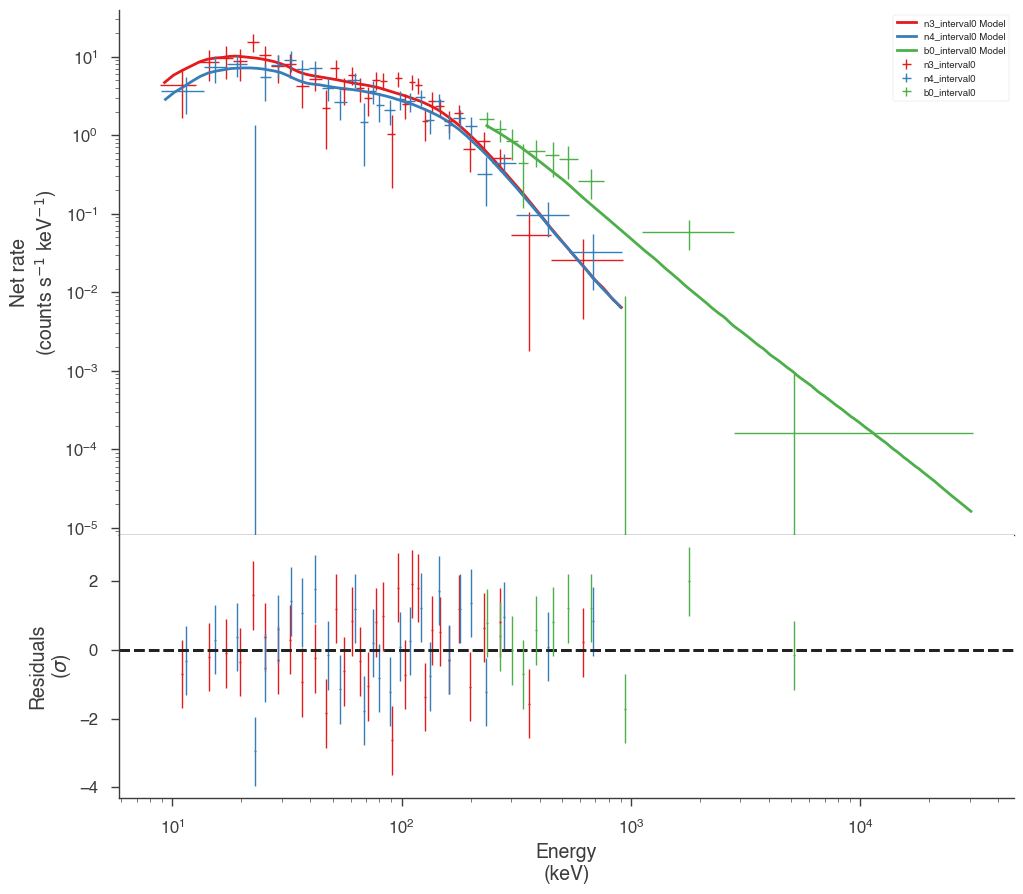

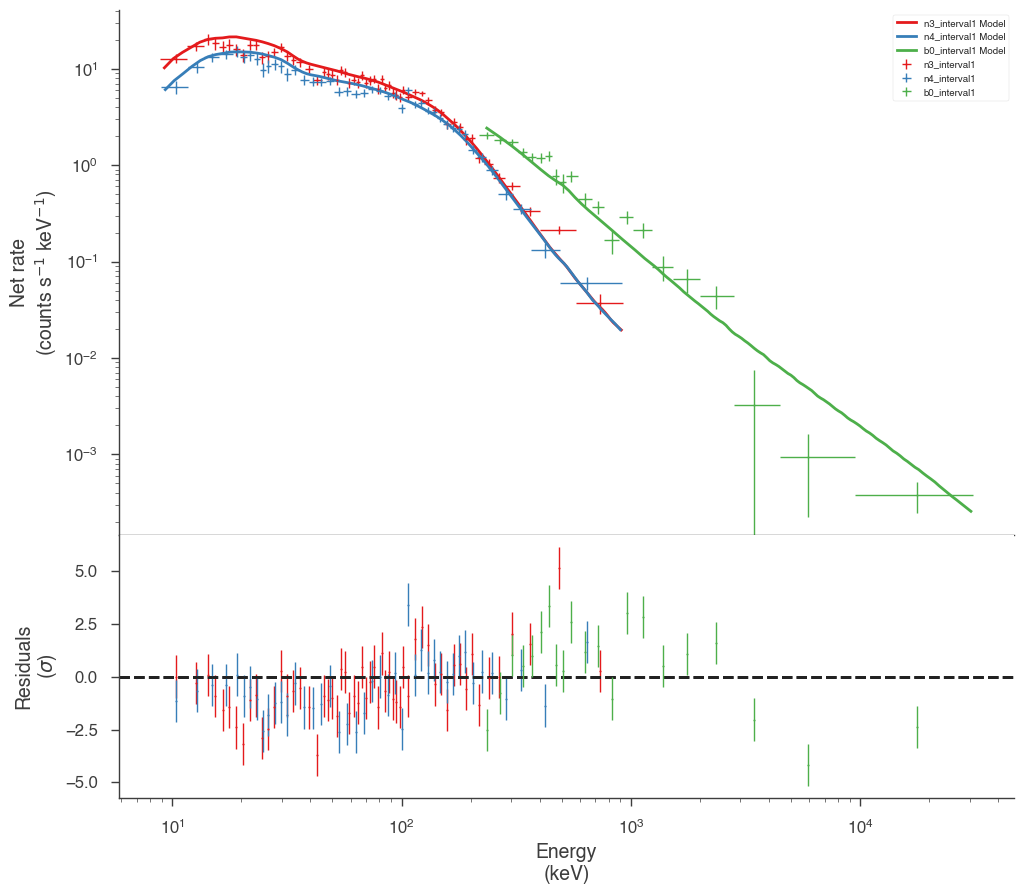

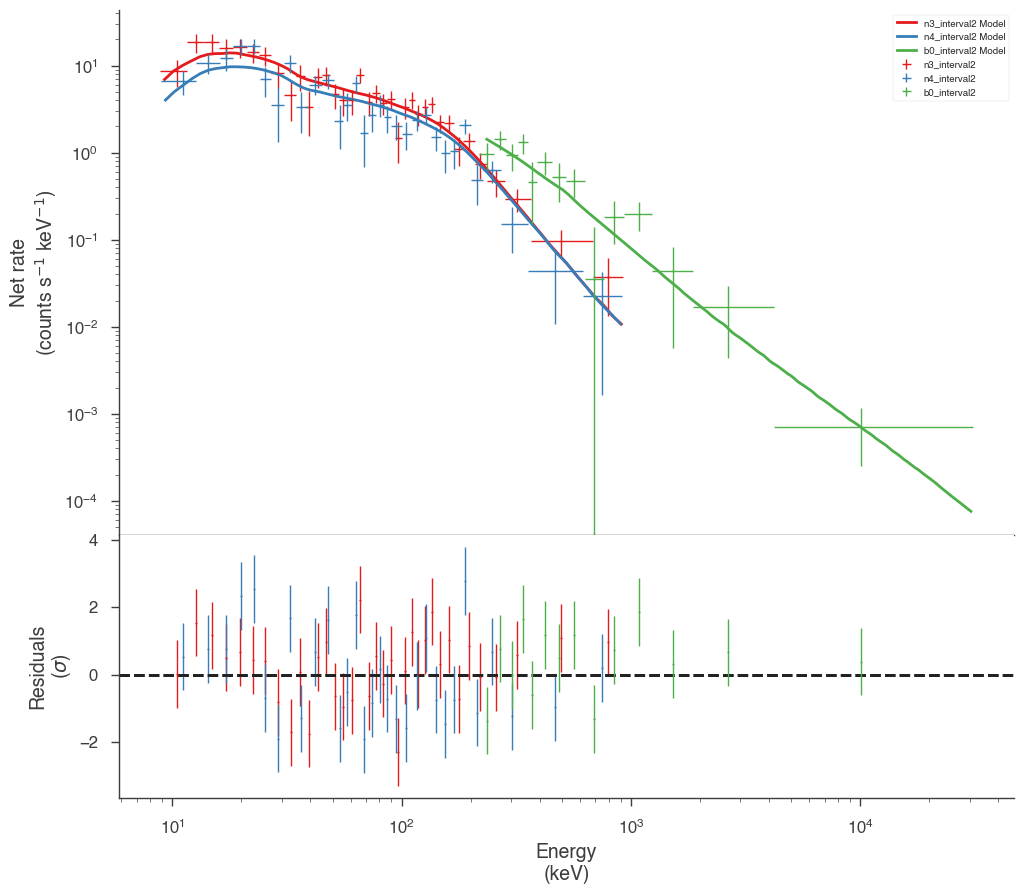

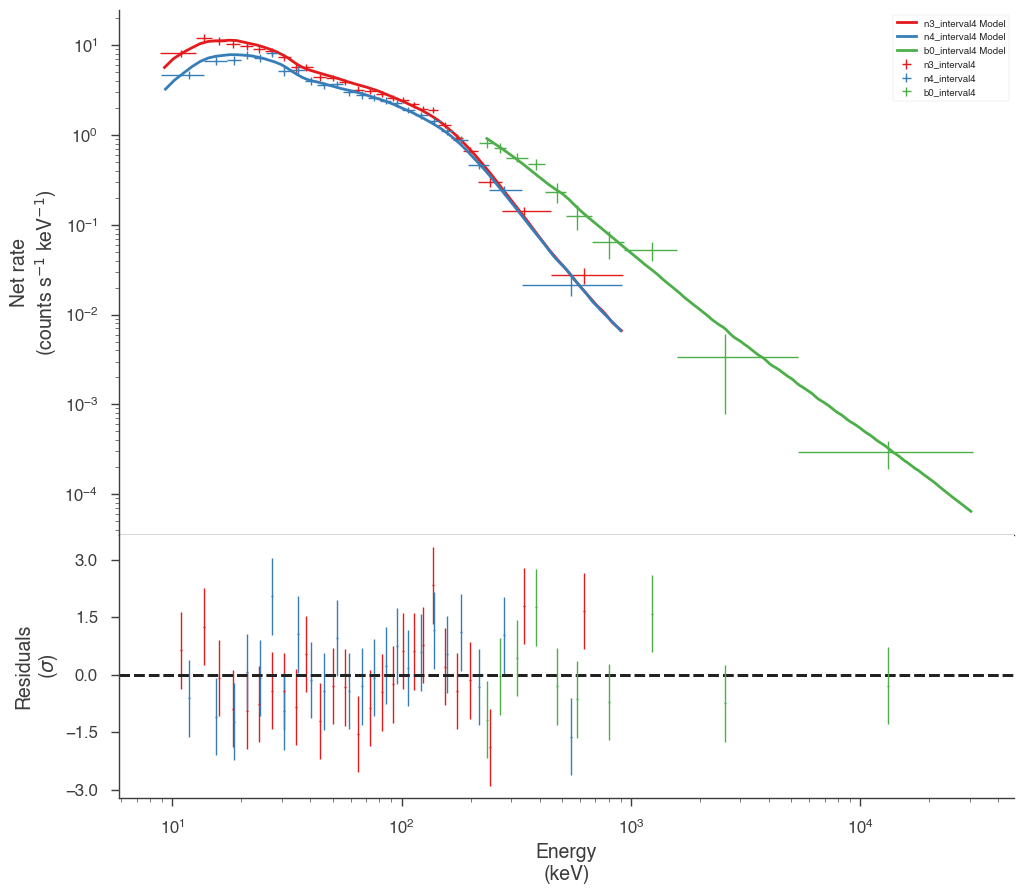

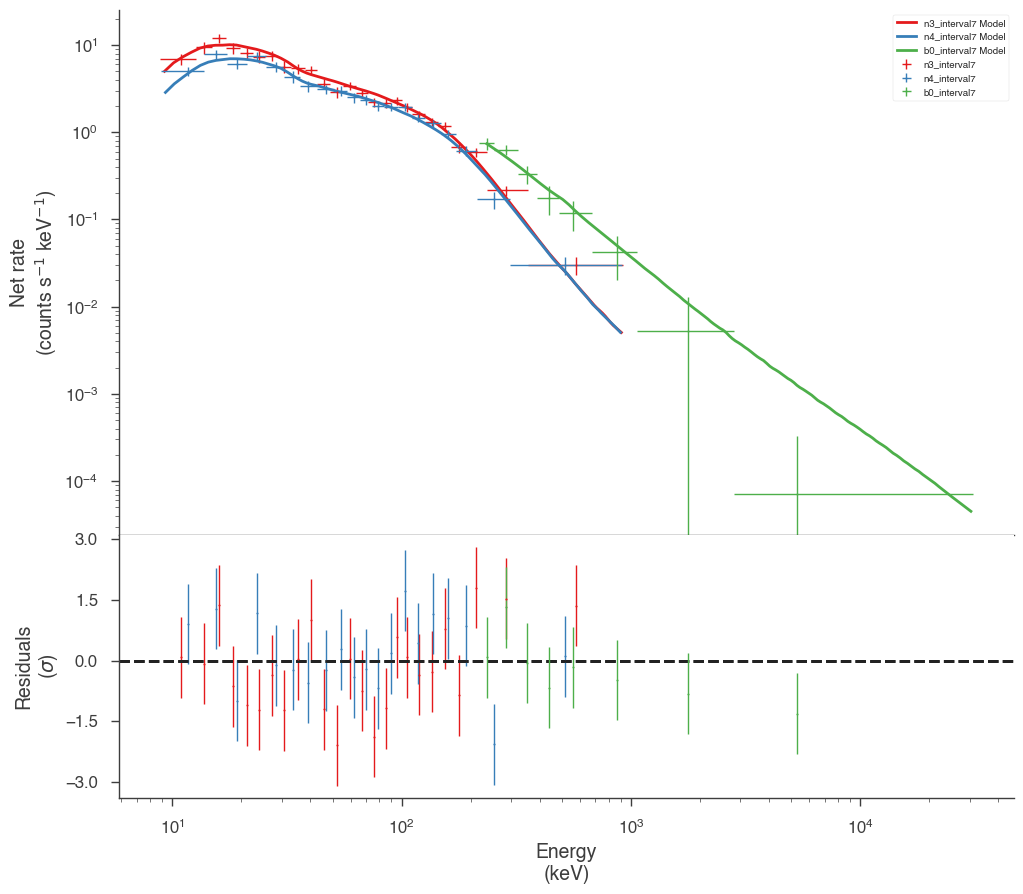

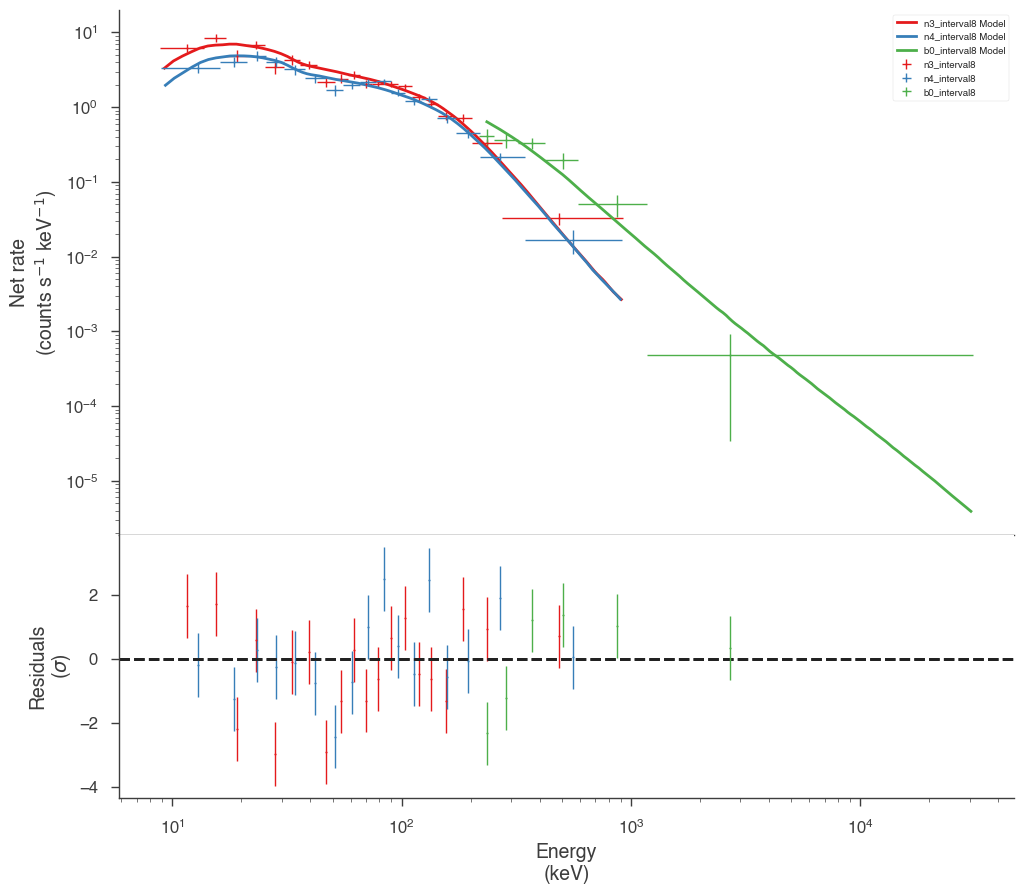

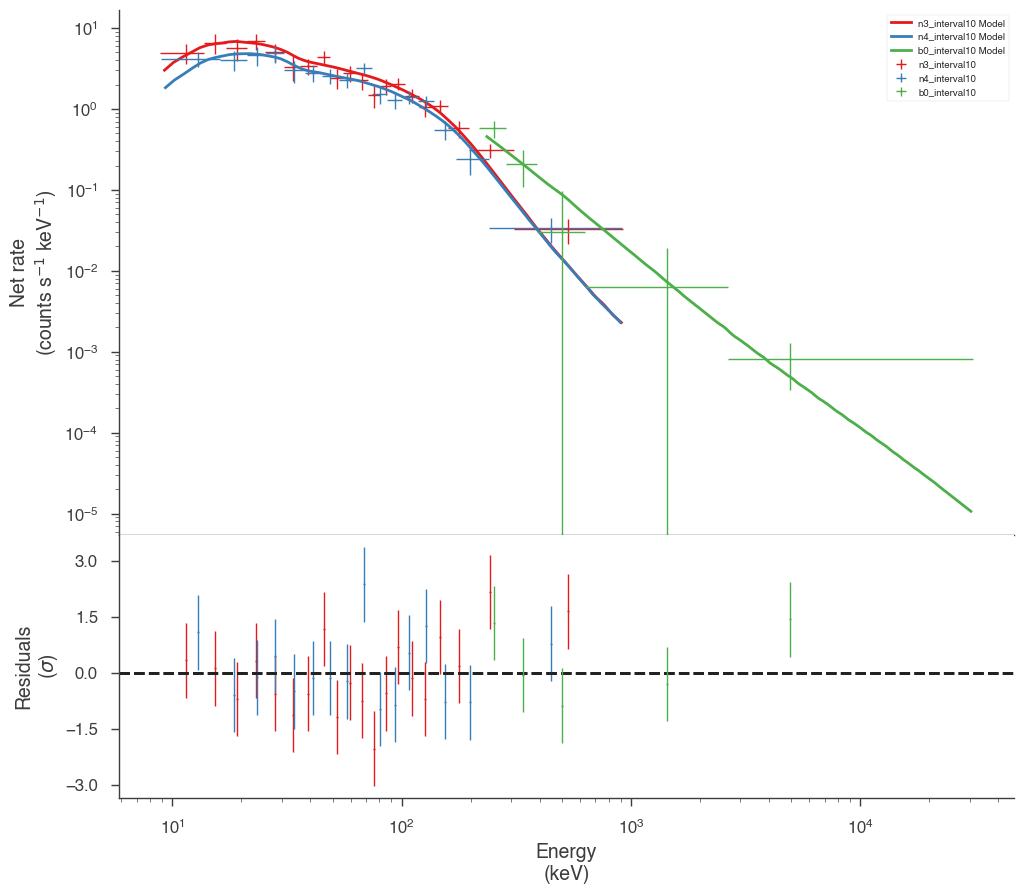

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

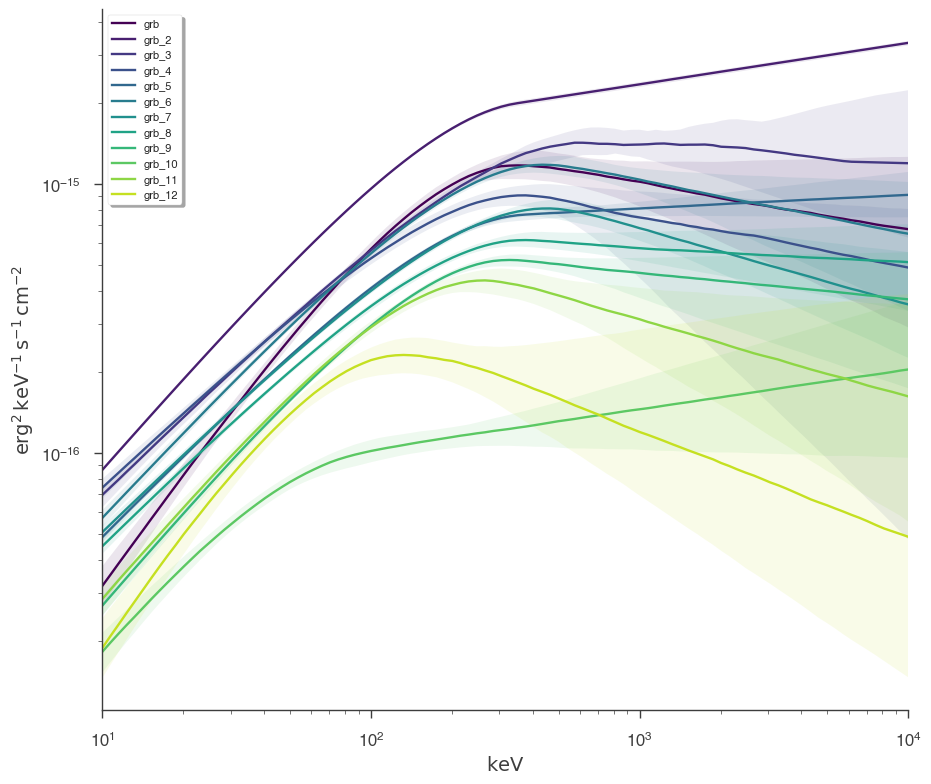

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.